# Cryptolytic Arbitrage Modeling

This notebook contains the code to create the arbitrage models used in the Cryptolytic project. You can find more information on data processing in this [notebook](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/1_arbitrage_data_processing.ipynb) and model evaluation in this [notebook](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/3_arbitrage_model_evaluation.ipynb).

<!-- <img src="https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/assets/cryptolytic_thumbnail.png?raw=true"
     alt=" "
     align= "center"
     style="width: 500px;" /> -->
     
#### What is arbitrage?
Arbitrage occurs when there is a price difference between the same asset in two different markets. So with crypto, it’s possible to have the same coin priced differently on separate exchanges. For example with bitcoin, you might have bitcoin priced at 8,000 on one exchange, and at the same time that bitcoin can be priced at 8,100 on another exchange. You can buy the bitcoin on the first exchange for 8,000, send it to the other exchange, and sell it for 8,100. Now you’ve made 100 in profit and you can repeat this process as long as that arbitrage opportunity lasts.

#### Background on arbitrage models
There are many different combinations of arbitrage that could be occuring at any given moment among all the cryptocurrency exchanges. Our goal was to capture as many of these as possible in order to create an API that provides predictions for any arbitrage opportunities that will occur in the next 10 minutes. This API could then serve as the backend for a web application that displays the predictions in a more user-friendly format.

The arbitrage models in this notebook predict arbitrage 10 min before it happens, lasting for at least 30 mins. It's important that the arbitrage window lasts long enough because it takes time to move coins from one exchange to the other in order to successfully complete the arbitrage trades. The datasets used for modeling are generated by getting all of the combinations of 2 exchanges that support the same trading pair, engineering technical analysis features, merging that data on 'closing_time', engineering more features, and creating a target that signals an arbitrage opportunity. Arbitrage signals predicted by the models have a direction indicating which direction the arbitrage occurs in.

#### What kind of machine learning problem is this?
Arbitrage can occur in two directions, one from the the first exchange to the second and vice versa, so there are 3 possible classes for a target which makes this a multiclass classification problem.

The targets are:
- 1: arbitrage from exchange 1 to exchange 2 starting 10 mins after prediction time, lasting 30 mins
- 0: no arbitrage 10 mins after prediction time
- -1: arbitrage from exchange 2 to exchnage 1 starting 10 mins after prediction time, lasting 30 mins

Random Forest Classifiers were used for modeling since they would work well with multiclass targets and imbalanced time series data.

#### What models were created?
After looking at the class distributions among the datasets of the 95 possible combinations, there were 6 options that contained enough of each target class to generate useful models. Instead of creating only one model to predict arbitrage 10 minutes out for any arbitrage combination, we chose to create individual models so that the model could better learn the nuances of that particular cryptocurrency pair:

- cbpro_bitfinex_eth_usd
- bitfinex_hitbtc_bch_usdt
- cbpro_bitfinex_ltc_usd
- bitfinex_hitbtc_ltc_usdt
- hitbtc_cbpro_eth_usdc
- bitfinex_cbpro_btc_usd

#### Train/Test Split
We did a 70/30 train/test split on the data that fell anywhere in the range from Jun 2015 - Oct 2019. There was a 2 week gap left between the train and test sets to prevent data leakage. Cross validation was not suitable in this case because arbitrage opportunites were already scarce and doing a 5-fold cross validation on time series data only limited the training data for some already small datasets.

#### Features
The arbitrage training csv's contain over 100 technical analysis features, some of which are highly correlated. We removed any features that were correlated >95%, except the original OHLCV features that were from the raw datasets. There 87 features left after removing the ones that were highly correlated, down from 140. A before and after of removing correlated features is shown below:

<img src="https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/assets/corr_b_a.png?raw=true"
     alt="drawing"
     width="600"/>


The bright green and blue squares represent features that are the most highly correlated. The remaining large green squares in the second visualization are the original OHLCV features that we chose not to remove.

We then trained a random forest model on the `cbpro_bitfinex_ltc_usd` dataset with all 87 features to create different feature sets with the most important features. Feature importance was determined using sklearn's `feature_importances_` method. The top 20 features for `cbpro_bitfinex_ltc_usd` were:

<img src="https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/assets/feat_imp.png?raw=true"
     alt="drawing"
     width="600"/>
     
We used the top 25, 50, 70, and 85 features to iterate on models. All feature sets used can be found in a txt file [here](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/data/features.txt).

#### Baseline
As a baseline, we created 6 Logistic Regression models with the lbfgs solver and 6 Random Forest models, one for each arbitrage combination. For training, we used the following 14 features that contained no technical analysis:

- open_exchange_1
- high_exchange_1
- low_exchange_1
- close_exchange_1
- base_volume_exchange_1
- open_exchange_2
- high_exchange_2
- low_exchange_2
- close_exchange_2
- base_volume_exchange_2
- higher_closing_price
- pct_higher
- arbitrage_opportunity
- window_length

#### Modeling
After running baseline models, we trained the Logistic Regression and Random Forest models using the additional technical analysis features - this was 25, 50, 70, and 85 extra features. 8 new models were trained for each arbitrage combination.


#### Hyperparameter tuning
The 70 most important features were then used for tuning the `max_depth`, `max_features`, and `n_estimators` parameters on Random Forest models:
 - max_depth: [12, 15, 17, 19, 21, 25]
 - max_features: ['auto', 50, 55, 60, 70]
 - n_estimators: [100, 150]
 
60 new models were trained for each arbitrage combination during hyperparamer tuning.

A total of 420 models were trained in this notebook.

#### Model Evaluation Criteria
After training each model, we calculated evaluation metrics and added it to a csv for later use. These metrics were:
 - Accuracy Score
 - Mean Percent Profit *
 - Median Percent Profit *
 - False Positive Rate (0 class)
 - Precison (-1, 0, 1 classes) 
 - Recall (-1, 0, 1 classes) 
 - F1 Score (-1, 0, 1 classes)

\* The profit calculation incorporates fees like in the real world. We used mean percent profit as the profitability metric which represented the average percent profit per arbitrage trade if one were to act on all trades predicted by the model in the testing period, whether those predictions were correct or not.

#### Results
Model performance is discussed in the evaluation [notebook](https://github.com/Cryptolytic-app/cryptolytic/blob/master/modeling/1_arbitrage_model_evaluation.ipynb)

#### Running this notebook 
Runtime approx. 2 hours

Data exported: less than 1 mb

- 2 txt files in `data/`
- 1 csv file in `data/`

Note:
It is highly recommended to run this on sagemaker (ml.m4.16xlarge instance) split train into 2 notebooks. There are 6 total options for models, and between baseline logistic regression, random forest, and random forest with hyperparameter tuning, 420 models will be trained. 

#### Directory Structure
```
├── cryptolytic/                        <-- Root directory   
│   ├── modeling/                       <-- Directory for modeling work
│   │      │
│   │      ├──assets/                   <-- Directory with png assets used in notebooks
│   │      │
│   │      ├──data/                     <-- Directory containing all data for project
│   │      │   ├─ arb_data/             <-- Directory for train data after merging + FE pt.2
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ arb_preds_test_data/  <-- Directory for test data w/ predictions
│   │      │   │   └── *.csv 
│   │      │   │
│   │      │   ├─ raw_data/             <-- Directory for raw training data
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ ta_data/              <-- Directory for csv files after FE pt.1 
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ zip_raw_data/         <-- Directory containing zip files of raw data
│   │      │   │   └── *.zip
│   │      │   │
│   │      │   ├─ features.txt          <-- All feature sets used in modeling
│   │      │   │
│   │      │   ├─ model_perf.csv        <-- Data from training baseline models and tuning
│   │      │   │
│   │      │   ├─ top_model_perf.csv    <-- Data from retraining and exporting best models
│   │      │   │
│   │      │   ├─ train_data_paths.txt  <-- Paths to training data that's used in modeling
│   │      │
│   │      ├── models/                  <-- Directory for all pickle models
│   │      │      └── *.zip
│   │      │
│   │      ├─ 1_arbitrage_data_processing.ipynb  <-- NB for data processing and creating csv
│   │      │
│   │      ├─ 2_arbitrage_modeling.ipynb         <-- NB for baseline models and tuning
│   │      │
│   │      ├─ 3_arbitrage_model_evaluation.ipynb <-- NB for model selection, eval, and viz
│   │      │
│   │      ├─ 4_trade_recommender_models.ipynb   <-- NB for trade recommender models
│   │      │
│   │      ├─ 5_tr_performance_viz.ipynb         <-- NB for trade recommender viz
│   │      │
│   │      ├─ environment.yml                    <-- Contains project dependencies
│   │      │
│   │      ├─ utils.py                           <-- All the functions used in modeling
│   │      │
```

## Imports

This project uses conda to manage environments.

In [100]:
# to update your conda env from a yml file from terminal
# conda env update --file modeling/environment.yml

# to export yml from terminal
# conda env export > modeling/environment.yml

# OR

# to export yml from terminal
# conda env export --no-builds > modeling/environment.yml

In [55]:
import glob
import os
import pickle
import json
import itertools
from zipfile import ZipFile
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

from ta import add_all_ta_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid

## Data

Open the serialized [txt file](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/data/train_data_paths.txt) that contains all the arbitrage datasets that should be used for modeling.

In [56]:
with open ('data/train_data_paths.txt', 'rb') as fp:
    train_data_paths = pickle.load(fp)
print(len(train_data_paths))
train_data_paths

6


['data/arb_data/hitbtc_cbpro_eth_usdc.csv',
 'data/arb_data/cbpro_bitfinex_ltc_usd.csv',
 'data/arb_data/bitfinex_hitbtc_bch_usdt.csv',
 'data/arb_data/cbpro_bitfinex_eth_usd.csv',
 'data/arb_data/bitfinex_cbpro_btc_usd.csv',
 'data/arb_data/bitfinex_hitbtc_ltc_usdt.csv']

Each dataset looks like this and should have 141 columns.

In [61]:
df = pd.read_csv(train_data_paths[4], index_col=0)
print(df.shape)
df.head()

(451520, 141)


,open_exchange_1,high_exchange_1,low_exchange_1,close_exchange_1,base_volume_exchange_1,nan_ohlcv_exchange_1,volume_adi_exchange_1,volume_obv_exchange_1,volume_cmf_exchange_1,volume_fi_exchange_1,volume_em_exchange_1,volume_vpt_exchange_1,volume_nvi_exchange_1,volatility_atr_exchange_1,volatility_bbh_exchange_1,volatility_bbl_exchange_1,volatility_bbm_exchange_1,volatility_bbhi_exchange_1,volatility_bbli_exchange_1,volatility_kcc_exchange_1,volatility_kch_exchange_1,volatility_kcl_exchange_1,volatility_kchi_exchange_1,volatility_kcli_exchange_1,volatility_dch_exchange_1,volatility_dcl_exchange_1,volatility_dchi_exchange_1,volatility_dcli_exchange_1,trend_macd_exchange_1,trend_macd_signal_exchange_1,trend_macd_diff_exchange_1,trend_ema_fast_exchange_1,trend_ema_slow_exchange_1,trend_adx_exchange_1,trend_adx_pos_exchange_1,trend_adx_neg_exchange_1,trend_vortex_ind_pos_exchange_1,trend_vortex_ind_neg_exchange_1,trend_vortex_diff_exchange_1,trend_trix_exchange_1,trend_mass_index_exchange_1,trend_cci_exchange_1,trend_dpo_exchange_1,trend_kst_exchange_1,trend_kst_sig_exchange_1,trend_kst_diff_exchange_1,trend_ichimoku_a_exchange_1,trend_ichimoku_b_exchange_1,trend_visual_ichimoku_a_exchange_1,trend_visual_ichimoku_b_exchange_1,trend_aroon_up_exchange_1,trend_aroon_down_exchange_1,trend_aroon_ind_exchange_1,momentum_rsi_exchange_1,momentum_mfi_exchange_1,momentum_tsi_exchange_1,momentum_uo_exchange_1,momentum_stoch_exchange_1,momentum_stoch_signal_exchange_1,momentum_wr_exchange_1,momentum_ao_exchange_1,momentum_kama_exchange_1,others_dr_exchange_1,others_dlr_exchange_1,others_cr_exchange_1,closing_time,open_exchange_2,high_exchange_2,low_exchange_2,close_exchange_2,base_volume_exchange_2,nan_ohlcv_exchange_2,volume_adi_exchange_2,volume_obv_exchange_2,volume_cmf_exchange_2,volume_fi_exchange_2,volume_em_exchange_2,volume_vpt_exchange_2,volume_nvi_exchange_2,volatility_atr_exchange_2,volatility_bbh_exchange_2,volatility_bbl_exchange_2,volatility_bbm_exchange_2,volatility_bbhi_exchange_2,volatility_bbli_exchange_2,volatility_kcc_exchange_2,volatility_kch_exchange_2,volatility_kcl_exchange_2,volatility_kchi_exchange_2,volatility_kcli_exchange_2,volatility_dch_exchange_2,volatility_dcl_exchange_2,volatility_dchi_exchange_2,volatility_dcli_exchange_2,trend_macd_exchange_2,trend_macd_signal_exchange_2,trend_macd_diff_exchange_2,trend_ema_fast_exchange_2,trend_ema_slow_exchange_2,trend_adx_exchange_2,trend_adx_pos_exchange_2,trend_adx_neg_exchange_2,trend_vortex_ind_pos_exchange_2,trend_vortex_ind_neg_exchange_2,trend_vortex_diff_exchange_2,trend_trix_exchange_2,trend_mass_index_exchange_2,trend_cci_exchange_2,trend_dpo_exchange_2,trend_kst_exchange_2,trend_kst_sig_exchange_2,trend_kst_diff_exchange_2,trend_ichimoku_a_exchange_2,trend_ichimoku_b_exchange_2,trend_visual_ichimoku_a_exchange_2,trend_visual_ichimoku_b_exchange_2,trend_aroon_up_exchange_2,trend_aroon_down_exchange_2,trend_aroon_ind_exchange_2,momentum_rsi_exchange_2,momentum_mfi_exchange_2,momentum_tsi_exchange_2,momentum_uo_exchange_2,momentum_stoch_exchange_2,momentum_stoch_signal_exchange_2,momentum_wr_exchange_2,momentum_ao_exchange_2,momentum_kama_exchange_2,others_dr_exchange_2,others_dlr_exchange_2,others_cr_exchange_2,year,month,day,higher_closing_price,pct_higher,arbitrage_opportunity,window_length,arbitrage_opportunity_shift,window_length_shift,target
0,278.04,278.05,277.99,277.99,9.115813,0.0,-11.656990,-98329.562325,-0.394465,2.499380,-0.000708,-0.005381,4940.888397,0.348091,279.038464,277.217536,278.1280,0.0,0.0,277.835667,278.187667,277.483667,0.0,0.0,278.86,277.51,0.0,0.0,-0.101287,-0.114734,0.013447,277.978647,278.079934,23.306749,23.459737,21.927422,0.814607,1.129213,0.314607,-0.005730,26.310518,-26.737524,-0.2480,-1.559092,-0.843776,-0.715315,278.0875,278.19,277.975,278.21,20.0,64.0,-44.0,48.141113,59.159859,-5.650201,40.157082,36.305732,46.912037,-63.694268,-0.184647,277.885884,-0.017983,-0.017985,-12.045181,2015-07-20 21:40:00,277.98,277.99,277.97,277.97,1.5

## Modeling Functions

#### Print Statements

In [62]:
line = '-------------'
sp = '      '

def print_model_name(name, i, train_data_paths):
    print(
    '\n\n', line*8, '\n\n', 
    f'Model {i+1}/{len(train_data_paths)}: {name}', '\n', 
    line*8
    )

def print_model_params(i, params, pg_list): 
    print(
        sp*2, line*5, '\n', 
        sp*2, f'Model {i+1}/{len(pg_list)}', '\n',  
        sp*2, f'params={params if params else None}', '\n', 
        sp*2, line*5
    )

#### Calculating Profit

In [63]:
# specifying arbitrage window length to target, in minutes
interval = 30

def get_higher_closing_price(df):
    """
    Returns the exchange with the higher closing price.
    """
    # exchange 1 has higher closing price
    if (df['close_exchange_1'] - df['close_exchange_2']) > 0:
        return 1
    # exchange 2 has higher closing price
    elif (df['close_exchange_1'] - df['close_exchange_2']) < 0:
        return 2
    # closing prices are equivalent
    else:
        return 0

def get_close_shift(df, interval=interval):
    """
    Shifts the closing prices by the selected interval + 10 mins.
    
    Returns a df with new features:
    - close_exchange_1_shift
    - close_exchange_2_shift
    """
    rows_to_shift = int(-1 * (interval/5))
    df['close_exchange_1_shift'] = df['close_exchange_1'].shift(
        rows_to_shift - 2)
    df['close_exchange_2_shift'] = df['close_exchange_2'].shift(
        rows_to_shift - 2)
    
    return df

def get_profit(df):
    """
    Calculates the profit of an arbitrage trade. Returns df with
    new profit feature.
    """
    # if exchange 1 has the higher closing price
    if df['higher_closing_price'] == 1:
        # return how much money you would make if you bought 
        # on exchange 2, sold on exchange 1, and took account 
        # of 0.55% fees
        return (((df['close_exchange_1_shift'] 
                  / df['close_exchange_2']) - 1) * 100) - 0.55
    # if exchange 2 has the higher closing price
    elif df['higher_closing_price'] == 2:
        # return how much money you would make if you bought 
        # on exchange 1, sold on exchange 2, and took account 
        # of 0.55% fees
        return (((df['close_exchange_2_shift'] / 
                 df['close_exchange_1']) -1) * 100) - 0.55
    # if the closing prices are the same
    else:
        return 0

def profit(X_test, y_preds):
    """ 
    Calculate mean/median percent profit for the test set.
    """
    test_with_preds = X_test.copy()
    test_with_preds['higher_closing_price'] = test_with_preds.apply(
            get_higher_closing_price, axis=1)

    # shift closing price to be able to calculate the price difference
    # between the correct interval
    test_with_preds = get_close_shift(test_with_preds)
    
    test_with_preds['pred'] = y_preds
    test_with_preds['pct_profit'] = test_with_preds.apply(
            get_profit, axis=1).shift(-2)

    # filter out rows where no arbitrage is predicted
    test_with_preds = test_with_preds[test_with_preds['pred'] != 0]

    pct_profit_mean = round(test_with_preds['pct_profit'].mean(), 2)
    pct_profit_median = round(test_with_preds['pct_profit'].median(), 2)
    
    return pct_profit_mean, pct_profit_median

#### Parameters

In [64]:
def create_pg(param_grid):
    """
    Creates a list of hyperparameter options to set the
    parameters on random forest models.
    """
    if not param_grid:
        pg_list = [param_grid]
    # checks if the params in param_grid are iterable
    # and if not, it turns them into iterables to be used 
    # with ParameterGrid()
    else:
        for key in param_grid:
            if isinstance(param_grid[key], list):         
                pg_list = list(ParameterGrid(param_grid))
            else:
                pg_list = [param_grid]
    return pg_list

#### Model Naming Conventions

In [65]:
def model_names(param_grid, params, csv_name, model_label):
    """
    Create unique model names
    """
    if param_grid:
        model_id = '_'.join([
            csv_name, 
            model_label,
            str(params['max_features']), 
            str(params['max_depth']), 
            str(params['n_estimators'])
        ])
    else:
        model_id = csv_name + '_' + model_label
    model_path = f'models/{model_id}.pkl'
    return model_id, model_path

#### Train/Test Split

In [66]:
def ttsplit(df, features, target):
    """
    Performs 80/20 train/test split with given features and
    target. Leaves a 2 week gap between the train and test sets
    to prevent data leakage. Returns X_train, X_test, y_train, 
    y_test, test
    """
    # determine cutoff times to split the data and remove 
    # remove 2 weeks from the end of the train set
    tt_split_row = round(len(df)*.82)
    tt_split_time = df['closing_time'][tt_split_row]
    cutoff_time = tt_split_time - dt.timedelta(days=14)

    # train and test subsets
    train = df[df['closing_time'] < cutoff_time]
    test = df[df['closing_time'] > tt_split_time]
    
    # X, y matrix
    X_train = train[features]
    X_test = test[features]
    y_train = train[target]
    y_test = test[target]
    
    print(sp*2, 'train and test shape: ', train.shape, test.shape)
    
    return X_train, X_test, y_train, y_test, test

#### Evaluation Metrics

In [67]:
def model_eval(X_test, y_test, y_preds, model_id, csv_name, 
               model_label, params):
    """
    Calculates model evaluation metrics using the confusion matrix 
    and classification report. Returns a dictionary containing the
    new metrics.
    """
    accuracy = accuracy_score(y_test, y_preds)
    pct_prof_mean, pct_prof_median = profit(X_test, y_preds)
    print(sp*2,'percent profit mean:', pct_prof_mean)
    print(sp*2, 'percent profit median:', pct_prof_median, '\n\n')
    
    # labels for confusion matrix
    unique_y_test = y_test.unique().tolist()
    unique_y_preds = list(set(y_preds))
    labels = list(set(unique_y_test + unique_y_preds))
    labels.sort()
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]

    # create confusion matrix and classification report
    conf_mat = pd.DataFrame(
        confusion_matrix(y_test, y_preds),
        columns=columns, index=index
    )
    class_report = classification_report(
        y_test, 
        y_preds, 
        digits=4, 
        output_dict=True
    )
    print(conf_mat, '\n')
    print(classification_report(y_test, y_preds, digits=4), '\n')
    
    # confusion matrix has -1, 0, 1 predictions
    if ('Predicted 1' in conf_mat.columns 
         and 'Predicted -1' in conf_mat.columns):
        fpr = (
            (conf_mat['Predicted 0'][0] + 
            conf_mat['Predicted 0'][2])/conf_mat['Predicted 0'].sum()
        )
        correct_arb_neg1 = conf_mat['Predicted -1'][0]
        correct_arb_1 = conf_mat['Predicted 1'][2]
        correct_arb = correct_arb_neg1 + correct_arb_1
        
        precision_neg1 = class_report['-1']['precision']
        precision_0 = class_report['0']['precision']
        precision_1 = class_report['1']['precision']
        recall_neg1 = class_report['-1']['recall']
        recall_0 = class_report['0']['recall']
        recall_1 = class_report['1']['recall']
        f1_neg1 = class_report['-1']['f1-score']
        f1_0 = class_report['0']['f1-score']
        f1_1 = class_report['1']['f1-score']
        
    # confusion matrix has 0, 1 predictions
    elif 'Predicted 1' in conf_mat.columns:
        fpr = (
            conf_mat['Predicted 0'][1] / 
            conf_mat['Predicted 0'].sum()
        )

        correct_arb_neg1 = 0
        correct_arb_1 = conf_mat['Predicted 1'][1]
        correct_arb = correct_arb_neg1 + correct_arb_1
        
        precision_neg1 = np.nan
        precision_0 = class_report['0']['precision']
        precision_1 = class_report['1']['precision']
        recall_neg1 = np.nan
        recall_0 = class_report['0']['recall']
        recall_1 = class_report['1']['recall']
        f1_neg1 = np.nan
        f1_0 = class_report['0']['f1-score']
        f1_1 = class_report['1']['f1-score']
        
    # confusion matrix has 0, -1 predictions
    elif 'Predicted -1' in conf_mat.columns:
        fpr = conf_mat['Predicted 0'][0] / conf_mat['Predicted 0'].sum()

        correct_arb_neg1 = conf_mat['Predicted -1'][0]
        correct_arb_1 = 0
        correct_arb = correct_arb_neg1 + correct_arb_1
        
        precision_neg1 = class_report['-1']['precision']
        precision_0 = class_report['0']['precision']
        precision_1 = np.nan
        recall_neg1 = class_report['-1']['recall']
        recall_0 = class_report['0']['recall']
        recall_1 = np.nan
        f1_neg1 = class_report['-1']['f1-score']
        f1_0 = class_report['0']['f1-score']
        f1_1 = np.nan
        
    # confusion matrix has only 0 predictions
    else:
        fpr = np.nan
        
        correct_arb_neg1 = 0
        correct_arb_1 = 0
        correct_arb = 0
        
        precision_neg1 = np.nan
        precision_0 = class_report['0']['precision']
        precision_1 = np.nan
        recall_neg1 = np.nan
        recall_0 = class_report['0']['recall']
        recall_1 = np.nan
        f1_neg1 = np.nan
        f1_0 = class_report['0']['f1-score']
        f1_1 = np.nan
    
    eval_dict = {
        'model_id': model_id, 
        'csv_name': csv_name, 
        'model_label': model_label,
        'params': params,  
        'accuracy': accuracy,
        'pct_profit_mean': pct_prof_mean, 
        'pct_profit_median': pct_prof_median,
        'fpr': fpr, 
        'correct_arb_neg1': correct_arb_neg1, 
        'correct_arb_1': correct_arb_1,
        'correct_arb': correct_arb, 
        'precision_neg1': precision_neg1, 
        'precision_0': precision_0, 
        'precision_1': precision_1, 
        'recall_neg1': recall_neg1, 
        'recall_0': recall_0, 
        'recall_1': recall_1,
        'f1_neg1': f1_neg1, 
        'f1_0': f1_0, 
        'f1_1': f1_1
    }
    
    return eval_dict   

#### Exports 

In [68]:
def export_handler(model, model_id, test, y_preds, 
                   export_model=False, export_preds=False):
    """
    Determines whether models and predictions should be exported
    and exports accordingly.
    """
    if export_model == True:  
        pickle.dump(
            model, 
            open(f'models/{model_id}.pkl', 'wb')
        )
    if export_preds == True:
        predictions = pd.DataFrame(
            columns=['closing_time', 'close_exchange_1', 
                     'close_exchange_2', 'y_test', 'y_preds'])
        # need to use test bc X_test doesn't have closing_time
        predictions['closing_time'] = test['closing_time']
        predictions['close_exchange_1'] = test['close_exchange_1']
        predictions['close_exchange_2'] = test['close_exchange_2']
        predictions['y_test'] = test['target'].tolist()
        predictions['y_preds'] = y_preds
        predictions.to_csv(
            f'data/arb_preds_test_data/{model_id}.csv', 
            index=False
        )

#### Model Training

In [69]:
def create_models(train_data_paths, model_type, features, param_grid, 
                  filename, export_preds=False, export_model=False):
    """
    This function takes in a list of all the training data paths, 
    does train/test split, feature selection, trains models, and 
    prints + exports evaluation stats for each model. Optional:
    export model (.pkl) and test predictions (.csv).

    Predictions
    ___________
    
    Models predict whether arbitrage will occur in 10 mins from the 
    prediction time, and last for at least 30 mins:
    1: arbitrage from exchange 1 to exchange 2
    0: no arbitrage
    -1: arbitrage from exchange 2 to exchange 1
    
    Evaluation
    __________
    
    - Accuracy Score
    - Mean Percent Profit
    - Median Percent Profit
    - False Positive Rate (FPR)
    - Precision
    - Recall
    - F1 score

    Parameters
    __________
    
    train_data_paths: filepaths for all the datasets used in modeling
    model_type: scikit-learn model (LogisticRegression() or 
        RandomForestClassifier())
    features: the features for training {'model_label': [list of features]}
        acceptable model labels include: [bl, 100_feat, 75_feat, 50_feat, 
        25_feat, hyper] 
        ex: {'bl': feature_sets['bl']}
    param_grid: the params used for hyperparameter tuning or empty {} 
    filename: CSV path for exporting model evaluation stats
    export_preds: exports prediction CSV if True (default=False)
    export_model: exports pkl model if True (default=False)
    """   
    # create model label
    base_model_name = str(model_type).split('(')[0]
    model_name_dict = {
        'LogisticRegression': 'lr',
        'RandomForestClassifier': 'rf'
    }
    feat_type = [k for k in features.keys()][0]
    model_label = model_name_dict[base_model_name] + '_' + feat_type   
    
    # open or create df for evaluation metrics
    file = Path(filename)
    columns = ['model_id', 'csv_name', 'model_label', 'params', 
               'accuracy', 'pct_profit_mean', 'pct_profit_median', 
               'fpr', 'correct_arb_neg1', 'correct_arb_1', 
               'correct_arb', 'precision_neg1', 'precision_0', 
               'precision_1', 'recall_neg1', 'recall_0', 'recall_1', 
               'f1_neg1', 'f1_0', 'f1_1']
    if file.exists(): 
        mp_df = pd.read_csv(filename)
    else:
        mp_df = pd.DataFrame(columns=columns)
    
    pg_list = create_pg(param_grid)
    target = 'target'
    
    for i, path in enumerate(train_data_paths):
        csv_name = path.split('/')[2].split('.')[0]
        print_model_name(csv_name, i, train_data_paths)
        df = pd.read_csv(path, index_col=0)
        # closing_time is a string after reading csv so convert to df
        df['closing_time'] = pd.to_datetime(df['closing_time'])
        X_train, X_test, y_train, y_test, test = ttsplit(
            df, 
            features[feat_type], 
            target
        )

        # filter out small datasets
        if ((X_train.shape[0] > 1000) 
            and (X_test.shape[0] > 100) 
            and len(set(y_train)) > 1):
            # hyperparameter tuning - iterate through parameter combos
            for i, params in enumerate(pg_list): 
                # define the model name and path
                model_id, model_path = model_names(
                    param_grid, 
                    params, 
                    csv_name, 
                    model_label
                )
                
                # model_id does not exist in performance csv
                if mp_df[mp_df['model_id'] == model_id].empty:
                    print_model_params(i, params, pg_list)
                    
                    # set params, train model, predict, evaluate
                    model = model_type.set_params(**params)
                    model = model.fit(X_train, y_train)
                    y_preds = model.predict(X_test)
                    eval_dict = model_eval(
                        X_test, 
                        y_test, 
                        y_preds, 
                        model_id, 
                        csv_name, 
                        model_label, 
                        params
                    )
                    mp_df = mp_df.append(eval_dict, ignore_index=True)
                    print(f'{sp*2}Appended row: model id-{model_id}')

                    # export model/prediction csv
                    export_handler(
                        model, 
                        model_id, 
                        test,
                        y_preds, 
                        export_model, 
                        export_preds
                    ) 
                else:
                    print(f'{sp*2}model id exists:{model_id}')
        else:
            print(f'{sp*2} ERROR: dataset too small for {csv_name}')

        # export evaluation df - end of one arbitrage combination
        mp_df.to_csv(filename, index=False)

## Features

The arbitrage training csv's contain over 100 technical analysis features, some of which are highly correlated. We want to remove the correlated features using a correlation matrix and then export them as a .txt file for version control.

#### Correlation Matrix

First let's look at the correlation matrix to see what features are correlated.

In [73]:
# read csv to plot correlation matrix
df = pd.read_csv(train_data_paths[1], index_col=0)
corr_df = df.corr()

def plot_corr(corr_df, size):
    """
    Plots a correlation matrix from a correlation dataframe with the 
    specified figure size.
    """
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(size, size))
    
    ax = sns.heatmap(
        corr_df, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(255, 133, l=60, n=7, center="dark"),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    
    plt.show()

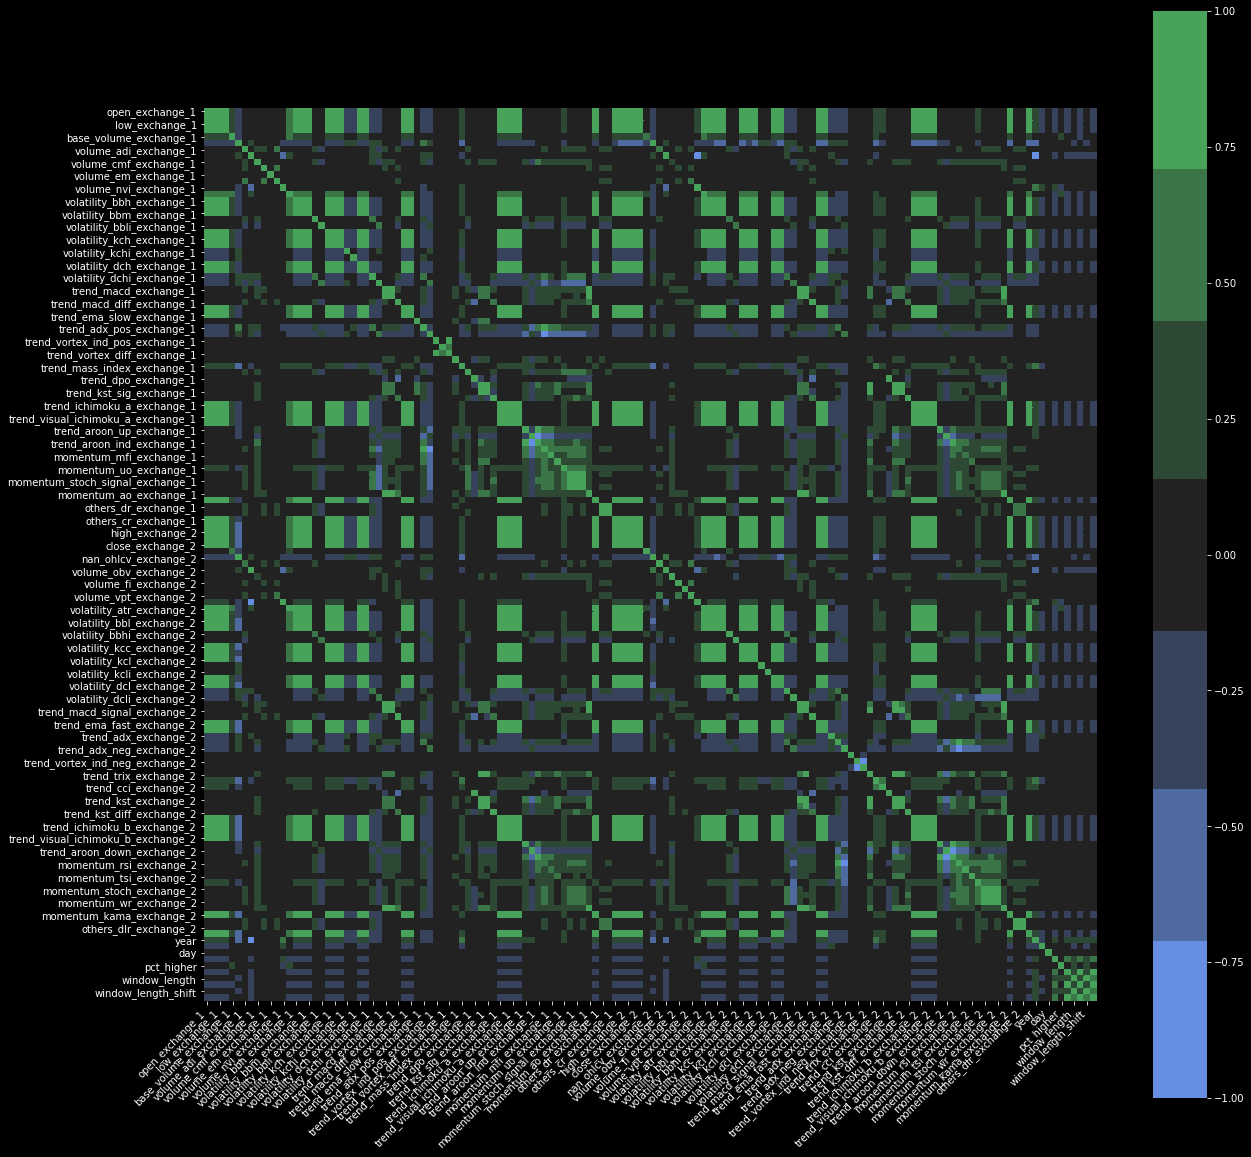

In [74]:
plot_corr(corr_df, size=20)

All of the bright green and blue blocks mean the features are correlated, so those are the ones we want to remove.

#### Removing Correlated Features

We're going to keep the original OHLCV features from the raw data and filter the rest of the features that have > 95% correlation.

In [76]:
# base features to keep - these are the features from raw data
base_feat = ['open_exchange_1', 'high_exchange_1','low_exchange_1','close_exchange_1','base_volume_exchange_1',   
              'open_exchange_2','high_exchange_2','low_exchange_2','close_exchange_2','base_volume_exchange_2',
              'higher_closing_price','pct_higher','arbitrage_opportunity','window_length']

# drop unused features from both index and columns
drop_feat = ['target', 'arbitrage_opportunity_shift', 'window_length_shift']
filt_df = corr_df.drop(columns=drop_feat)
filt_df = filt_df.drop(drop_feat)

# remove correlated features
for col in filt_df.columns:
    for i in range(len(filt_df)):
        idx = filt_df.index[i]
        if idx not in base_feat and col != idx:
            if idx in filt_df.index[i:]:
                if filt_df[col].loc[idx] > 0.95 or filt_df[col].loc[idx] < -0.95:
                    filt_df = filt_df.drop(idx)
        if i == len(filt_df) - 1:
            break

# filter columns for the uncorrelated features on index
features_uncorr = filt_df.index.to_list()
filt_df = filt_df[features_uncorr]

print('Original Features:', len(corr_df))
print('Features after filtering:', len(filt_df))

Original Features: 140
Features after filtering: 87


We're left with 87 features after removing the correlated ones and now we can look at the correlation matrices side by side to see the difference. The only highly correlated features (big green squares) left after filtering are the original features from the raw data.

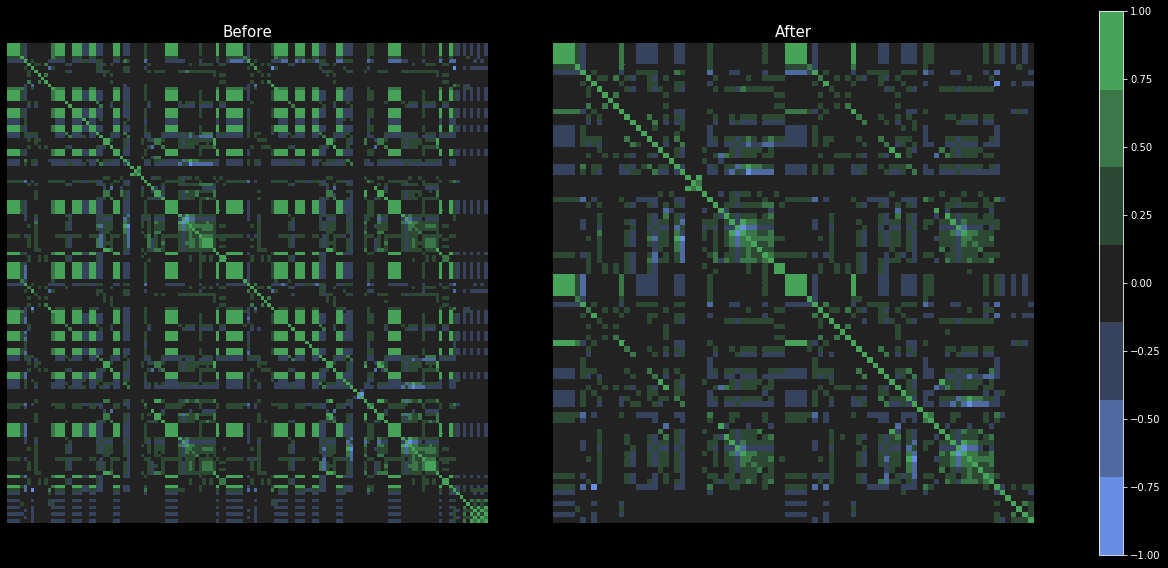

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,10),  gridspec_kw=dict(width_ratios=[4,4,0.2]))

# corr heatmap before filter
sns.heatmap(
    corr_df, 
    vmin=-1, vmax=1, center=0,
    ax=ax[0],
    cbar=False,
    yticklabels=False,
    xticklabels=False,
    cmap=sns.diverging_palette(255, 133, l=60, n=7, center="dark"),
    square=True
    )

# corr heatmap after filtering
sns.heatmap(
    filt_df, 
    vmin=-1, vmax=1, center=0,
    ax=ax[1],
    cbar=False,
    yticklabels=False,
    xticklabels=False,
    cmap=sns.diverging_palette(255, 133, l=60, n=7, center="dark"),
    square=True
    )

# color bar on col 3
fig.colorbar(ax[1].collections[0], cax=ax[2])

# title
ax[0].set_title('Before', fontsize=15)
ax[1].set_title('After', fontsize=15)

plt.show()

#### Plot Feature Importances

Now that we've removed uncorrelated features, we also want to breakdown features sets based on their features importances so we could iterate on the models.

<!-- Note: this function does not work with multiple csv's. Need's to be fixed -->

In [82]:
def plot_feature_importances(train_data_paths):
    """
    Creates a bar plot visualization showing a model's top 20 features
    given the csv paths for arbitrage data.
    """
    # import features
    with open('data/features.txt') as json_file:
        feature_sets = json.load(json_file)

    mfi = []
    pkls = []
    titles = {}
    n = 0
    
    # train models
    create_models(
        train_data_paths=train_data_paths, 
        model_type=RandomForestClassifier(
            n_jobs=-1, 
            random_state=42
        ), 
        features={'all': features_uncorr},
        param_grid={},
        filename = 'data/model_perf_fi.csv',
        export_model=True
    )
    
    for path in train_data_paths:
        pkl = glob.glob(f'models/{path.split("/")[2][:-4]}*.pkl')[0]
        pkls.append(pkl)
    
    # generate titles and feature importances
    for pkl in pkls:
        with open(pkl, 'rb') as f:
            model = pickle.load(f)
            titles[n] = pkl.split('/')[1].split('.')[0]
            n += 1

        imp = pd.DataFrame(model.feature_importances_, features_uncorr).reset_index()
        imp = imp.rename(columns={'index': 'features', 0: 'importance'})
        imp = imp.sort_values(by='importance', ascending=False)[:20][::-1]
        mfi.append(imp)
    
    # plot importances
    plt.style.use('dark_background')
    ncols = 2 if len(pkls) > 1 else 1
    nrows = len(pkls)/2 if len(pkls) > 1 else 1
    
    if len(pkls) > 1:
        fig, ax = plt.subplots(
            nrows=nrows, 
            ncols=ncols, 
            figsize=(15, len(pkls)*6)
        )
        plt.subplots_adjust(wspace=1)
    else:
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 7))
        plt.subplots_adjust(wspace=3)
    
    if len(pkls) > 1:
        n = 0
        for row in ax:
            for col in row:
                try:
                    col.barh(
                        mfi[n]['features'], 
                        mfi[n]['importance'], 
                        color='#4EB9FF'
                    )
                    col.set_yticklabels = mfi[n]['features']
                    col.set_title(titles[n])
                    col.set_xlabel('Feature Importance')
                    n += 1
                except:
                    pass
    else:
        n = 0
        ax.barh(mfi[n]['features'], mfi[n]['importance'], color='#4EB9FF')
        ax.set_yticklabels = mfi[n]['features']
        ax.set_title(titles[n])
        ax.set_xlabel('Feature Importance')

    plt.show()



 -------------------------------------------------------------------------------------------------------- 

 Model 1/1: cbpro_bitfinex_ltc_usd 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (273337, 141) (60885, 141)
            model id exists:cbpro_bitfinex_ltc_usd_rf_all


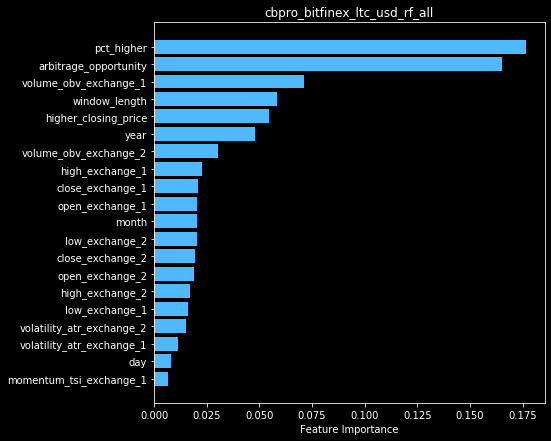

In [83]:
plot_feature_importances(['data/arb_data/cbpro_bitfinex_ltc_usd.csv'])

#### Export Features

In [84]:
# create empty dict that will hold the feature sets
feature_sets = {}

# baseline features, no TA features
feature_sets['bl'] = ['open_exchange_1', 'high_exchange_1','low_exchange_1','close_exchange_1', 'base_volume_exchange_1',   
                      'open_exchange_2', 'high_exchange_2', 'low_exchange_2', 'close_exchange_2', 'base_volume_exchange_2',
                      'higher_closing_price', 'pct_higher', 'arbitrage_opportunity', 'window_length']

# all features
feature_sets['all'] = features_uncorr

# load model
with open('models/cbpro_bitfinex_ltc_usd_rf_all.pkl', 'rb') as f:
    model = pickle.load(f)

# get top features
imp = pd.DataFrame(model.feature_importances_, features_uncorr).reset_index()
imp = imp.rename(columns={'index': 'features', 0: 'importance'})
imp85 = imp.sort_values(by='importance', ascending=False)[:85][::-1]
imp70 = imp.sort_values(by='importance', ascending=False)[:70][::-1]
imp50 = imp.sort_values(by='importance', ascending=False)[:50][::-1]
imp25 = imp.sort_values(by='importance', ascending=False)[:25][::-1]
top_features = imp['features'].to_list()

# append new feature sets to dict
feature_sets['85_feat'] = imp85['features'].to_list()
feature_sets['70_feat'] = imp70['features'].to_list()
feature_sets['50_feat'] = imp50['features'].to_list()
feature_sets['25_feat'] = imp25['features'].to_list()


# # # UNCOMMENT TO RE-EXPORT FEATURES.TXT. THIS WILL OVERWRITE 
# # # EXISTING FILE WITH NEW FEATURE SETS.

# # export file
# with open('data/features.txt', 'w') as file:
#     json.dump(feature_sets, file)

## Loading feature dictionary

In [99]:
with open('data/features.txt') as json_file:
    feature_sets = json.load(json_file)
    
feature_sets.keys()

dict_keys(['bl', 'all', '85_feat', '70_feat', '50_feat', '25_feat'])

## Baseline Models

#### Logistic Regression w/ no TA Features

In [86]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=LogisticRegression(
        solver='lbfgs', 
        multi_class='multinomial',
        random_state=42
    ), 
    features={'bl': feature_sets['bl']}, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/6: hitbtc_cbpro_eth_usdc 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (69852, 141) (16217, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 1.28
             percent profit median: 1.24 


           Predicted -1  Predicted 0  Predicted 1
Actual -1          2073          874            0
Actual 0            354         8740          307
Actual 1              4         2077         1788 

              precision    recall  f1-score   support

          -1     0.8527    0.7034    0.7709      2947
           0     0.7476    0.9297    0.8288      9401
           1     0.8535    

#### Random Forest Classifier w/ no TA Features

In [87]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features={'bl': feature_sets['bl']}, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/6: hitbtc_cbpro_eth_usdc 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (69852, 141) (16217, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 0.88
             percent profit median: 0.71 


           Predicted -1  Predicted 0  Predicted 1
Actual -1          1217         1728            2
Actual 0            365         8385          651
Actual 1              5         1784         2080 

              precision    recall  f1-score   support

          -1     0.7669    0.4130    0.5368      2947
           0     0.7048    0.8919    0.7874      9401
           1     0.7611    

## Models with TA features

Using the new feature sets created above, we train logistic regression and random forest models with the top 25, 50, 70, and 85 features.

#### Logistic Regression w/ 85 features & default parameters

In [88]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=LogisticRegression(
        solver='lbfgs', 
        multi_class='multinomial',
        random_state=42
    ), 
    features={'85_feat': feature_sets['85_feat']}, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/6: hitbtc_cbpro_eth_usdc 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (69852, 141) (16217, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: nan
             percent profit median: nan 


           Predicted -1  Predicted 0  Predicted 1
Actual -1             0         2947            0
Actual 0              0         9401            0
Actual 1              0         3869            0 

              precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000      2947
           0     0.5797    1.0000    0.7339      9401
           1     0.0000    0.

#### Logistic Regression w/ 70 features & default parameters

In [89]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=LogisticRegression(
        solver='lbfgs', 
        multi_class='multinomial',
        random_state=42
    ), 
    features={'70_feat': feature_sets['70_feat']}, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/6: hitbtc_cbpro_eth_usdc 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (69852, 141) (16217, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: nan
             percent profit median: nan 


           Predicted -1  Predicted 0  Predicted 1
Actual -1             0         2947            0
Actual 0              0         9401            0
Actual 1              0         3869            0 

              precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000      2947
           0     0.5797    1.0000    0.7339      9401
           1     0.0000    0.

#### Logistic Regression w/ 50 features & default parameters

In [90]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=LogisticRegression(
        solver='lbfgs', 
        multi_class='multinomial',
        random_state=42
    ), 
    features={'50_feat': feature_sets['50_feat']}, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/6: hitbtc_cbpro_eth_usdc 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (69852, 141) (16217, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 0.84
             percent profit median: 0.77 


           Predicted -1  Predicted 0  Predicted 1
Actual -1           591         2203          153
Actual 0            551         8709          141
Actual 1            131         3493          245 

              precision    recall  f1-score   support

          -1     0.4643    0.2005    0.2801      2947
           0     0.6046    0.9264    0.7317      9401
           1     0.4545    

#### Logistic Regression w/ 25 features & default parameters

In [91]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=LogisticRegression(
        solver='lbfgs', 
        multi_class='multinomial',
        random_state=42
    ), 
    features={'25_feat': feature_sets['25_feat']}, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/6: hitbtc_cbpro_eth_usdc 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (69852, 141) (16217, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 1.11
             percent profit median: 1.3 


           Predicted -1  Predicted 0  Predicted 1
Actual -1           670         2092          185
Actual 0            430         8751          220
Actual 1            163         3238          468 

              precision    recall  f1-score   support

          -1     0.5305    0.2273    0.3183      2947
           0     0.6215    0.9309    0.7453      9401
           1     0.5361    0

#### Random Forest w/ 85 features & default parameters

In [92]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features={'85_feat': feature_sets['85_feat']}, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/6: hitbtc_cbpro_eth_usdc 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (69852, 141) (16217, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 0.92
             percent profit median: 0.75 


           Predicted -1  Predicted 0  Predicted 1
Actual -1          1291         1656            0
Actual 0            384         8357          660
Actual 1              3         1464         2402 

              precision    recall  f1-score   support

          -1     0.7694    0.4381    0.5583      2947
           0     0.7282    0.8889    0.8006      9401
           1     0.7845    

#### Random Forest w/ 70 features & default parameters

In [93]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features={'70_feat': feature_sets['70_feat']}, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/6: hitbtc_cbpro_eth_usdc 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (69852, 141) (16217, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 0.92
             percent profit median: 0.72 


           Predicted -1  Predicted 0  Predicted 1
Actual -1          1098         1849            0
Actual 0            340         8344          717
Actual 1              4         1412         2453 

              precision    recall  f1-score   support

          -1     0.7614    0.3726    0.5003      2947
           0     0.7190    0.8876    0.7944      9401
           1     0.7738    

#### Random Forest w/ 50 features & default parameters

In [94]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features={'50_feat': feature_sets['50_feat']}, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/6: hitbtc_cbpro_eth_usdc 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (69852, 141) (16217, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 0.92
             percent profit median: 0.74 


           Predicted -1  Predicted 0  Predicted 1
Actual -1          1014         1933            0
Actual 0            314         8481          606
Actual 1              3         1728         2138 

              precision    recall  f1-score   support

          -1     0.7618    0.3441    0.4741      2947
           0     0.6985    0.9021    0.7874      9401
           1     0.7792    

#### Random Forest w/ 25 features & default parameters

In [95]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features={'25_feat': feature_sets['25_feat']}, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/6: hitbtc_cbpro_eth_usdc 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (69852, 141) (16217, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 0.87
             percent profit median: 0.67 


           Predicted -1  Predicted 0  Predicted 1
Actual -1           865         2081            1
Actual 0            301         8528          572
Actual 1              2         1947         1920 

              precision    recall  f1-score   support

          -1     0.7406    0.2935    0.4204      2947
           0     0.6792    0.9071    0.7768      9401
           1     0.7702    

## Hyperparameter Tuning
Since the models with 70 features performed best, we'll be using that same feature set to carry out hyperparameter tuning of the following parameters:
- max_depth
- n_estimators
- max_features

In [14]:
# 60 hyperparameter combinations
# 360 total models
create_models(
    train_data_paths=train_data_paths[:5], 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features={'70_feat_hyper': feature_sets['70_feat']}, 
    param_grid={'max_depth': [12, 15, 17, 19, 21, 25],
                'n_estimators': [100, 150],
                'max_features': ['auto', 50, 55, 60, 70]},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/5: bitfinex_cbpro_etc_usd 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (102923, 141) (23477, 141)
             ----------------------------------------------------------------- 
              Model 1/60 
              params={'max_depth': 12, 'max_features': 'auto', 'n_estimators': 100} 
              -----------------------------------------------------------------
             percent profit mean: 2.61
             percent profit median: 1.53 


           Predicted -1  Predicted 0  Predicted 1
Actual -1             0           26            0
Actual 0             34        22959           15
Actual 1              0          291          152 

              precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000        26
           0     0.9

## Model Performance

When baseline models are trained and hyperparameter tuning is done, we'll have a csv file in our data folder that looks like this. This is the data that will be analyzed in the evaluation notebook to choose the best models.

In [98]:
perf_df = pd.read_csv('data/model_perf.csv')
print(perf_df.shape) # (1290, 20)
perf_df.head()

(420, 20)


,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,fpr,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,hitbtc_cbpro_eth_usdc_lr_bl,hitbtc_cbpro_eth_usdc,lr_bl,{},0.777024,1.28,1.24,0.252416,2073,1788,3861,0.852735,0.747584,0.853461,0.703427,0.929688,0.462135,0.770919,0.828750,0.599598
1,cbpro_bitfinex_ltc_usd_lr_bl,cbpro_bitfinex_ltc_usd,lr_bl,{},0.957346,4.51,5.04,0.044642,208,4343,4551,0.722222,0.955358,0.998620,0.525253,0.998402,0.651515,0.608187,0.976406,0.788561
2,bitfinex_hitbtc_bch_usdt_lr_bl,bitfinex_hitbtc_bch_usdt,lr_bl,{},0.789168,1.22,0.83,0.211987,429,1421,1850,0.676656,0.788013,0.836867,0.358696,0.932211,0.585014,0.468852,0.854068,0.688636
3,cbpro_bitfinex_eth_usd_lr_bl,cbpro_bitfinex_eth_usd,lr_bl,{},0.858255,1.51,1.14,0.097918,161,5858,6019,0.851852,0.902082,0.605728,0.358575,0.929062,0.531097,0.504702,0.915374,0.565963
4,bitfinex_cbpro_btc_usd_lr_bl,bitfinex_cbpro_btc_usd,lr_bl,{},0.835886,2.57,2.22,0.195640,14327,324,14651,0.979825,0.804360,0.796069,0.527620,0.992956,0.708972,0.685896,0.888763,0.750000


## Limitations
The data sets for all models were split by a 80/20 train/test split, meaning that the size of the test data varies greatly for each model. The size of the test set is larger or smaller depending on the starting size of the merged dataset for the two exchanges. The % profit mean is the average percentage gained if one were to act on all arbitrage opportunities predicted by that specific model during the period of the test set. With a larger test set, there is a better chance of seeing more arbitrage predictions, and the % profit mean number will be more accurate as it's averaged over more observations. Right now, it's possible that the % profit mean is skewed due to different testing timeframes where more or less arbitrage predictions are observed. When more data is available, it may be more accurate to apply evaluation metrics to the last 500 arbitrage predictions by the model so that you can make valid comparisons between models.

## Next Steps For Modeling
- More hyperparameter tuning
- Neural Networks
- Implement auto model retraining in the cloud
- Create a trigger that checks for model decay
- Retrain models in cloud if decayed, select best performers, save new version to S3 Buckets
- Save train/test data of newest version for reference
- Create a bot that will act on arbitrage predictions from models

## Continued...
Model selection, evaluation, and visualization of performance will be carried out in the following notebook:
- [View on Github](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/3_arbitrage_model_evaluation.ipynb)

- [Jump to local copy](3_arbitrage_model_evaluation.ipynb)